In [103]:
import torch 
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Resize, Compose, Normalize, CenterCrop
import torch.optim as optim

import matplotlib.pyplot as plt


In [112]:
# Set up training data
output_size = 512

train_data = datasets.Food101(root='data', 
                            split='train', 
                            download=True,
                            transform=Compose([
                                    Resize(output_size),  # Resize the shorter side to output_size
                                    CenterCrop(output_size),  # Crop the center part of the image to get a square image
                                    ToTensor()]),
                            target_transform=None)

test_data = datasets.Food101(root='data',
                            split='test',
                            download=True,
                            transform=Compose([
                                    Resize(output_size),  # Resize the shorter side to output_size
                                    CenterCrop(output_size),  # Crop the center part of the image to get a square image
                                    ToTensor()]),
                            target_transform=None)

In [113]:
len(train_data), len(test_data)



(75750, 25250)

In [114]:
class_names = train_data.classes
print(class_names)
len(class_names)

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

101

In [115]:
image, label = train_data[2]

In [116]:
train_data[0][0].shape

torch.Size([3, 512, 512])

Image shape: torch.Size([3, 512, 512])


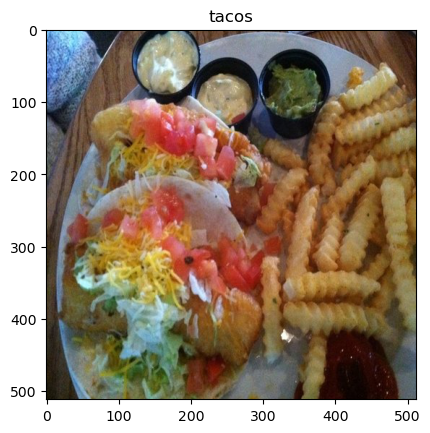

In [117]:
# Visualize the data

import matplotlib.pyplot as plt
image, label = train_data[7530]
print(f"Image shape: {image.shape}")
plt.imshow(image.permute(1,2,0).squeeze())
plt.title(class_names[label]);

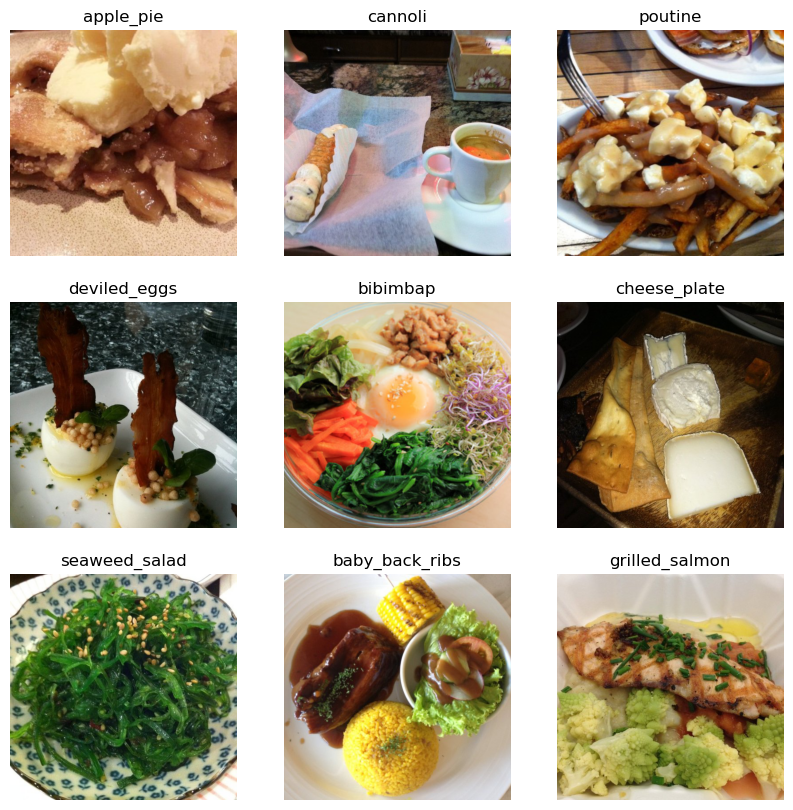

In [122]:
# Plot more images
#torch.manual_seed(42)

plt.figure(figsize=(10, 10))
n_rows, n_cols = 3, 3
for i in range(n_rows * n_cols):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    image, label = train_data[random_idx]
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(image.permute(1,2,0).squeeze())
    plt.title(class_names[label])
    plt.axis('off')



In [123]:
from torch.utils.data import DataLoader

BATCH_SIZE = 16

train_dataloader = DataLoader(train_data, 
                            batch_size=BATCH_SIZE, 
                            shuffle=True)

test_dataloader = DataLoader(test_data,
                            batch_size=BATCH_SIZE,
                            shuffle=False)

In [124]:
print(f"DataLoaders: {train_dataloader, test_dataloader}")
print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}...")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}...")

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x0000015DAA6A2190>, <torch.utils.data.dataloader.DataLoader object at 0x0000015DBA916510>)
Length of train_dataloader: 4735 batches of 16...
Length of test_dataloader: 1579 batches of 16...


In [125]:

train_features_batch, train_labels_batch = (next(iter(train_dataloader)))
train_features_batch.shape, train_labels_batch.shape




(torch.Size([16, 3, 512, 512]), torch.Size([16]))

In [126]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

In [146]:
# Create a CNN Model

import torch.nn.functional as F
class Food101Model(nn.Module):
    def __init__(self,
                input_shape: int=3,
                hidden_units: int=512,
                num_classes: int=101,
                ):
        super().__init__()
        self.conv1_block = nn.Sequential(
            nn.Conv2d(
            in_channels=input_shape,
            out_channels=hidden_units,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        
        nn.ReLU(),
        
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        
        nn.ReLU(),
        
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        
        nn.ReLU(),
        
        nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.conv2_block = nn.Sequential(
            nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        
        nn.ReLU(),
        
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        
        nn.ReLU(),
        
        nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.conv3_block = nn.Sequential(
            nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        
        nn.ReLU(),
        
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        
        nn.ReLU(),
        
        nn.MaxPool2d(kernel_size=2, stride=2)
        )
    
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_units * 64 * 64, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, num_classes)
        )
    
    def forward(self, x):
        x = self.conv1_block(x)
        print(f"Conv1 shape: {x.shape}")
        x = self.conv2_block(x)
        print(f"Conv2 shape: {x.shape}")
        x = self.conv3_block(x)
        print(f"Conv3 shape: {x.shape}")
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        print(f"Classifier shape: {x.shape}")
        return x

In [147]:
#Instantiate the model
Model_V1 = Food101Model(input_shape=3,
                        hidden_units=64,
                        num_classes=101).to(device)

In [148]:
rand_image_tensor = torch.rand(size=(3,512,512)).unsqueeze(0)
Model_V1(rand_image_tensor.to(device))

Conv1 shape: torch.Size([1, 64, 256, 256])
Conv2 shape: torch.Size([1, 64, 128, 128])
Conv3 shape: torch.Size([1, 64, 64, 64])
Classifier shape: torch.Size([1, 101])


tensor([[ 0.0915, -0.0994,  0.0973,  0.0621,  0.1102,  0.0811, -0.0657,  0.0960,
          0.0599,  0.0816,  0.0528,  0.0866,  0.0300, -0.0532, -0.0241,  0.0525,
         -0.0186,  0.1174, -0.0896, -0.0349, -0.0991,  0.0989,  0.1092, -0.0225,
          0.0122,  0.0440, -0.0455, -0.0771, -0.0602,  0.0149, -0.0804, -0.0837,
         -0.0431,  0.0076,  0.0296,  0.0399,  0.0706,  0.1171, -0.0845,  0.0213,
         -0.0472,  0.1020, -0.0698,  0.0180,  0.0577,  0.0262, -0.0046,  0.1098,
          0.0106, -0.0301,  0.1091,  0.0011,  0.0231, -0.0593,  0.0593, -0.0045,
         -0.0322, -0.1128, -0.0137, -0.0759,  0.0510, -0.0375, -0.1321,  0.1115,
         -0.1174, -0.0539, -0.0909,  0.0932,  0.0894,  0.0457, -0.0908, -0.1021,
         -0.0624,  0.1016, -0.0096,  0.1149, -0.0174, -0.0977, -0.1084, -0.1008,
          0.1031,  0.0696, -0.0234,  0.0852, -0.0615, -0.1169, -0.0406, -0.0239,
          0.1249, -0.1010, -0.0543,  0.0007, -0.0432,  0.0481, -0.1086,  0.0474,
         -0.0230, -0.0361,  

In [149]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=Model_V1.parameters(),
                            lr=0.1)

In [151]:
from helper_functions import accuracy_fn

def train_step(model: torch.nn.Module,
                data_loader: torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                optimizer: torch.optim.Optimizer,
                accuracy_fn,
                device: torch.device):
    
    """
    Performs a single training step (forward pass, backward pass, optimizer step) and returns the loss and accuracy metrics.
    """
    # Initialize loss and accuracy values
    train_loss, train_acc = 0, 0
    
    model.to(device)
    
    # Put model into training mode
    model.train()
    
    # Add a loop to loop through the training batches
    for batch, (X, y) in enumerate(data_loader):
        
        # Move data and model to device
        X, y = X.to(device), y.to(device)
        
        # 1. Forward pass (outputs the raw logits)
        y_pred = model(X)
        
        # 2. Calculate loss and accuracy (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulate train loss
        train_acc += accuracy_fn(y_true=y,
                                    y_pred=y_pred.argmax(dim=1)) #logits --> labels
        
        
        # 3. Optimizer zero grad
        optimizer.zero_grad()
        
        # 4. Loss backward
        loss.backward()
        
        # 5. Optimizer step (update the model's parameters once *per batch*)
        optimizer.step()
        
    
    # Divide total train loss and accuracy by length of data_loader
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")


def test_step(model: torch.nn.Module,
                data_loader: torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                accuracy_fn,
                device: torch.device):
    """
    Performs a single test step (forward pass, calculate loss and accuracy) and returns the loss and accuracy metrics.
    """
    # Initialize loss and accuracy values
    test_loss, test_acc = 0, 0
    
    model.to(device)
    
    # Put the in evaluation mode and inference mode
    model.eval()
    with torch.inference_mode(): 
        for X, y in data_loader:
            
            # Move data and model to device
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss (accumulatively)
            test_loss += loss_fn(test_pred, y)
            
            # 3. Calculate accuracy
            test_acc += accuracy_fn(y_true=y,
                                    y_pred=test_pred.argmax(dim=1))
        
        # Divide total train loss and accuracy by length of data_loader
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%")

In [152]:
# Use the train_step function to train the model for 3 epochs.
from tqdm.auto import tqdm
# Set the seed and start the timer
import torch
torch.manual_seed(42)
from timeit import default_timer as timer


train_time_start_on_gpu = timer()
EPOCHS = 3

# Train the model for 3 epochs
for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch {epoch} of {EPOCHS}")
    
    # Train step
    train_step(model=Model_V1,
                data_loader=train_dataloader,
                loss_fn=loss_fn,
                optimizer=optimizer,
                accuracy_fn=accuracy_fn,
                device=torch.device(device))
    
    # Test step
    test_step(model=Model_V1,
                data_loader=test_dataloader,
                loss_fn=loss_fn,
                accuracy_fn=accuracy_fn,
                device=torch.device(device))

train_time_end_on_gpu = timer()

# Print the time it took to train the model
total_train_time_model_1 = train_time_end_on_gpu - train_time_start_on_gpu
print(f"Total training time: {total_train_time_model_1:.2f} seconds")

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0 of 3


OutOfMemoryError: CUDA out of memory. Tried to allocate 1024.00 MiB. GPU 0 has a total capacty of 6.00 GiB of which 0 bytes is free. Of the allocated memory 4.84 GiB is allocated by PyTorch, and 26.50 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF